<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/13_psm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from causalinference import CausalModel
from psmpy import PsmPy
from scipy import stats as st
import joblib
from scipy.stats import norm, ttest_ind
from tqdm import tqdm
from joblib import Parallel, delayed

# 1. Рассмотрим реальный кейс из классифайда недвижимости
В некоторые объявления о продаже квартир добавили дополнительный контентный блок (treatment). Блок ипотечного калькулятора. Для того чтобы увеличить конверсию в добавление объявления в Избранное (наш outcome, целевая конверсия). Конверсия не бинарная. Воспринимать лучше как CTR по этой объявке добавления в избранное по всем просмотрам.

In [ ]:
#загружаем данные
data = pd.read_csv('dataset_for_psm.csv', index_col = 0)
data

,year,floor,rooms,price,square,is_it_capital,treatment,cr,id
0,1975.00,5.00,1,8000,30.00,0,0,0.00,0
1,1970.00,2.00,1,8000,32.00,0,1,0.00,1
2,1980.00,1.00,1,7000,37.00,0,1,0.00,2
3,1975.00,3.00,1,5000,31.00,0,1,0.00,3
4,1985.00,8.00,1,10000,34.00,0,1,0.00,4
...,...,...,...,...,...,...,...,...,...
35149,1970.00,1.00,1,12000,36.00,0,1,0.00,35149
35150,1980.00,2.00,1,8000,33.00,0,1,0.00,35150
35151,2007.00,6.00,1,7500,38.00,1,1,0.00,35151
35152,1989.00,2.00,1,8000,30.00,0,1,0.00,35152


Загружаем данные где мы имеем CTR (cr), на которую хотим оценить влияние воздействия (treatment)

In [ ]:
treatment = 'treatment'
outcome = 'cr'

## 2. EDA

In [ ]:
# средняя конверсия
print('Средняя конверсия = ', round(data['cr'].mean(), 5))
print('Средняя конверсия в группе без воздействия = ', round(data['cr'][data['treatment'] == 0].mean(), 6))
print('Средняя конверсия в группе с воздействием = ', round(data['cr'][data['treatment'] == 1].mean(), 6))

Средняя конверсия =  0.00567
Средняя конверсия в группе без воздействия =  0.00567
Средняя конверсия в группе с воздействием =  0.005669


In [ ]:
# доля treatment в группах
print('Доля treatmnt group' , round(data.treatment.mean(), 3))

Доля treatmnt group 0.724


In [ ]:
# небольшой summary
df = data.copy()
df.groupby('treatment').mean()

,year,floor,rooms,price,square,is_it_capital,cr,id
treatment,,,,,,,,
0,1812.45,4.08,1.42,11292.01,48.43,0.37,0.01,12164.47
1,958.32,4.92,1.50,13623.90,50.77,0.49,0.01,19640.68


#### Посмотрим как распределены фичи нашего датасета  в зависимости treatment это или контроль

In [ ]:
df.treatment = df.treatment.astype(bool)
df = data.copy()

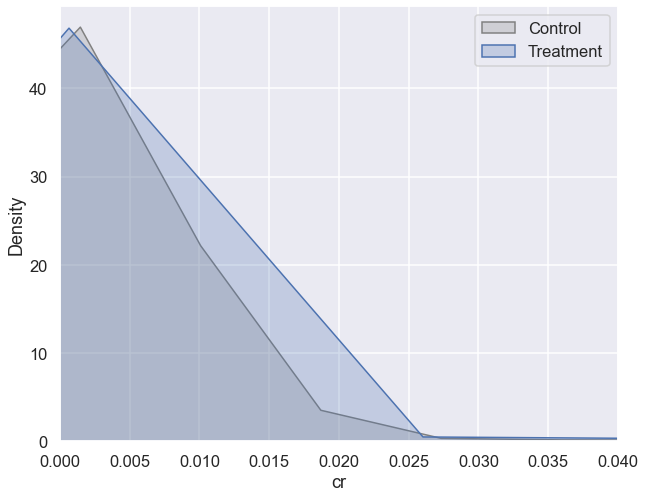

In [ ]:
# посмотрим небольшой кусочек распределения cr
sns.kdeplot(df[df['treatment']==0].cr, fill = True, label = 'Control', color = 'grey')
sns.kdeplot(df[df['treatment']==1].cr, fill = True, label = 'Treatment')
plt.xlim(0, 0.04)
plt.legend();

Оцениваем распределения метрики по treatment'у, где treatment = 0 - это контроль, а где 1 это treatment.

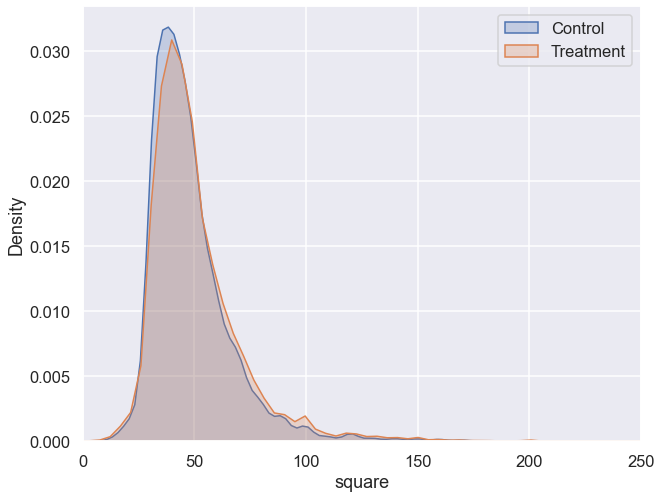

In [ ]:
# площадь квартиры
sns.kdeplot(data = df[df['treatment']==0], x = 'square', fill = True, label = 'Control')
sns.kdeplot(data = df[df['treatment']==1], x = 'square', fill = True, label = 'Treatment')
plt.xlim(0, 250)
plt.legend();

Так же давайте посмотрим на ковариаты, как они распределены по treatment'у. Первым делом это площадь, видим что в принципе распределения похожи

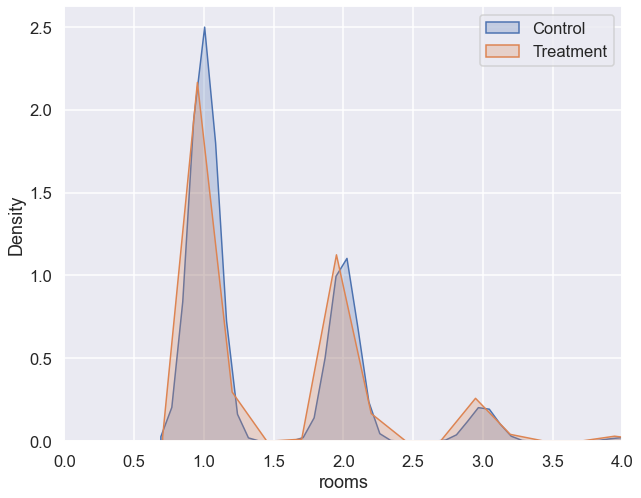

In [ ]:
# кол-во комнат квартиры
sns.kdeplot(data = df[df['treatment']==0], x = 'rooms', fill = True, label = 'Control')
sns.kdeplot(data = df[df['treatment']==1], x = 'rooms', fill = True, label = 'Treatment')
plt.xlim(0, 4)
plt.legend();

Похожая ситуация с ковариатой комнатностью

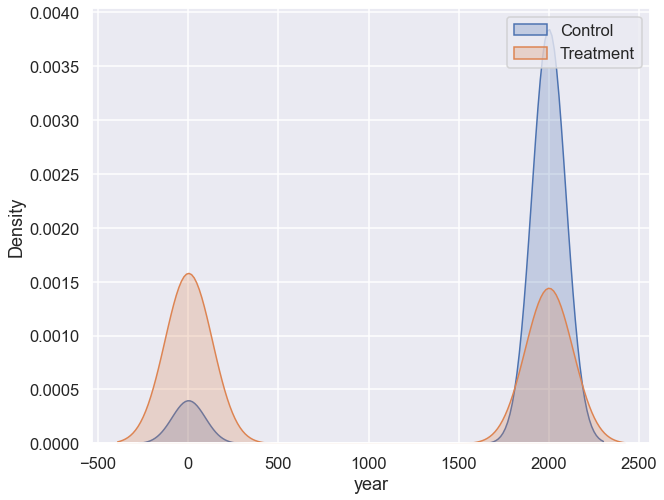

In [ ]:
# год постройки квартиры
sns.kdeplot(data = df[df['treatment']==0], x = 'year', fill = True, label = 'Control')
sns.kdeplot(data = df[df['treatment']==1], x = 'year', fill = True, label = 'Treatment')
plt.legend();

По ковариате году постройки, можем видеть что распределения не совсем равны, так как год постройки является необязательным параметром, при замене пустых значении на 0, больше всего было пустых в treatment, а в control было больше значении со средним 2000 годом постройки.

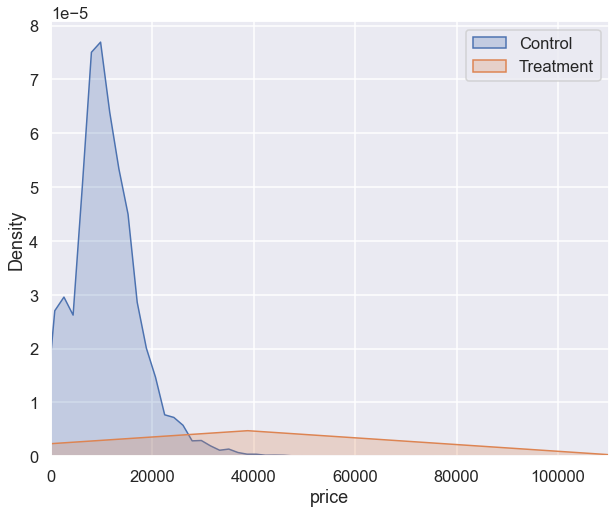

In [ ]:
# цена квартиры квартиры
sns.kdeplot(data = df[df['treatment']==0], x = 'price', fill  = True, label = 'Control')
sns.kdeplot(data = df[df['treatment']==1], x = 'price', fill = True, label = 'Treatment')
plt.xlim(0, 110000)
plt.legend();

По ценовой ковариате можно видеть что распределения очень сильно разнятся

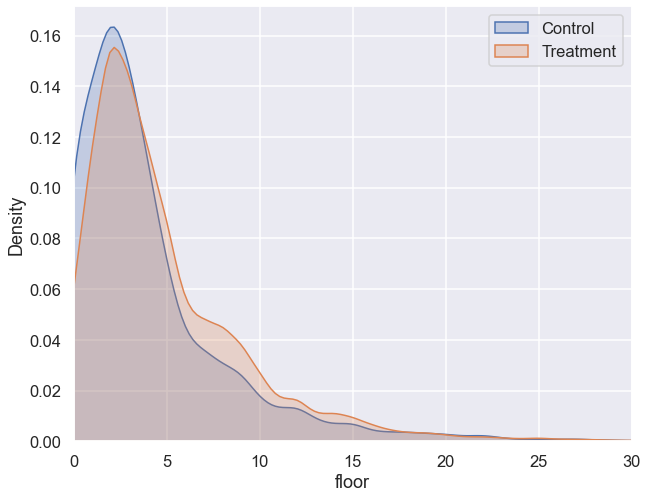

In [ ]:
# этаж на котором находится квартира
sns.kdeplot(data = df[df['treatment']==0], x = 'floor', fill = True, label = 'Control')
sns.kdeplot(data = df[df['treatment']==1], x = 'floor', fill = True, label = 'Treatment')
plt.xlim(0, 30)
plt.legend();

С ковариатой этажность особо проблем нет

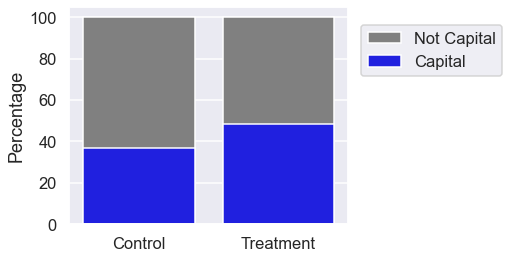

In [ ]:
c_label = 'Capital'
nc_label = 'Not Capital'
table_cap = 100 * pd.crosstab(df['treatment'].replace({1: 'Treatment',
                                                  0: 'Control'}),
                           df['is_it_capital'].replace({1: c_label,
                                                    0: nc_label}),
                           normalize = 'index')
table_cap['All'] = 100
plt.figure(figsize=(5, 4))
sns.barplot(data = table_cap, x = table_cap.index.astype(str),  y = "All",
            label = nc_label, color = 'gray')
sns.barplot(data = table_cap, x = table_cap.index.astype(str),  y = c_label,
            label = c_label, color = 'blue')
plt.legend(loc = 'center', bbox_to_anchor = (1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage');

По бинарной ковариате столица ли, можно видеть что в контрольной меньше столиц и это как-то может повлиять на метрику которую мы оцениваем (конверсия)

## 3. Обучаем PSM модель

Подготавливаем данные, делаем небольшой preprocessing ковариат с помощью стандартизации значении отняв среднее и поделив на стандартное отклонение

In [ ]:
# препроцессинг
X = df.drop(['id', 'cr', 'treatment'], axis = 1)
X_scaled = StandardScaler().fit_transform(X)
scaled_column_names = [column + '_scaled' for column in X.columns]
df_scaled = pd.DataFrame(X_scaled, columns=scaled_column_names)
df = pd.concat([df, df_scaled], axis = 1)

In [ ]:
df_ = df.copy()

In [ ]:
df_.head()

,year,floor,rooms,price,square,is_it_capital,treatment,cr,id,year_scaled,floor_scaled,rooms_scaled,price_scaled,square_scaled,is_it_capital_scaled
0,1975.00,5.00,1,8000,30.00,0,0,0.00,0,0.80,0.07,-0.66,-0.06,-0.91,-0.91
1,1970.00,2.00,1,8000,32.00,0,1,0.00,1,0.79,-0.60,-0.66,-0.06,-0.82,-0.91
2,1980.00,1.00,1,7000,37.00,0,1,0.00,2,0.80,-0.82,-0.66,-0.07,-0.59,-0.91
3,1975.00,3.00,1,5000,31.00,0,1,0.00,3,0.80,-0.38,-0.66,-0.10,-0.86,-0.91
4,1985.00,8.00,1,10000,34.00,0,1,0.00,4,0.81,0.74,-0.66,-0.04,-0.73,-0.91


In [ ]:
# попробуем для каждого наблюдения найти propensity_score и propensity_logit
to_exclude = X.columns.tolist()
to_exclude.append(outcome)
psm = PsmPy(df_, treatment=treatment, indx = 'id', exclude = to_exclude) # исключаем не скалированные колонки и обучаем psm
psm.logistic_ps(balance = False)
df_pred = psm.predicted_data.sort_values(by = 'id')
cols_tc = list(X.columns) + ['id']
df_pred = df_pred.merge(df_[cols_tc], on = ['id'])
df_pred.treatment = df_pred.treatment.astype(bool)
df_pred

,id,year_scaled,floor_scaled,rooms_scaled,price_scaled,square_scaled,is_it_capital_scaled,propensity_score,propensity_logit,treatment,year,floor,rooms,price,square,is_it_capital
0,0,0.80,0.07,-0.66,-0.06,-0.91,-0.91,0.55,0.19,False,1975.00,5.00,1,8000,30.00,0
1,1,0.79,-0.60,-0.66,-0.06,-0.82,-0.91,0.53,0.10,True,1970.00,2.00,1,8000,32.00,0
2,2,0.80,-0.82,-0.66,-0.07,-0.59,-0.91,0.51,0.04,True,1980.00,1.00,1,7000,37.00,0
3,3,0.80,-0.38,-0.66,-0.10,-0.86,-0.91,0.53,0.10,True,1975.00,3.00,1,5000,31.00,0
4,4,0.81,0.74,-0.66,-0.04,-0.73,-0.91,0.57,0.28,True,1985.00,8.00,1,10000,34.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35149,35149,0.79,-0.82,-0.66,-0.01,-0.64,-0.91,0.52,0.10,True,1970.00,1.00,1,12000,36.00,0
35150,35150,0.80,-0.60,-0.66,-0.06,-0.77,-0.91,0.52,0.09,True,1980.00,2.00,1,8000,33.00,0
35151,35151,0.83,0.29,-0.66,-0.07,-0.55,1.10,0.61,0.45,True,2007.00,6.00,1,7500,38.00,1
35152,35152,0.81,-0.60,-0.66,-0.06,-0.91,-0.91,0.52,0.08,True,1989.00,2.00,1,8000,30.00,0


На выходе мы получаем дополнительные колонки для исходного датафрейма в виде Propensity Score, Propensity Logit

Propensity Score - Логистическая регрессия, для y - treatment = 1, x - price, rooms, year, ... т.е. ковариаты. Propensity Score это вероятность быть в treatment'е имея фичи - x. Математически, это выглядит следующим образом: $P(T=1|X)$

Propensity Logit - В логистической регрессии есть логит-функция - это математическая функция, которая преобразовывает вероятность события [0, 1] в вещественное число в логарифмическом масштабе. С помощью этого и делается обычно сам matching.

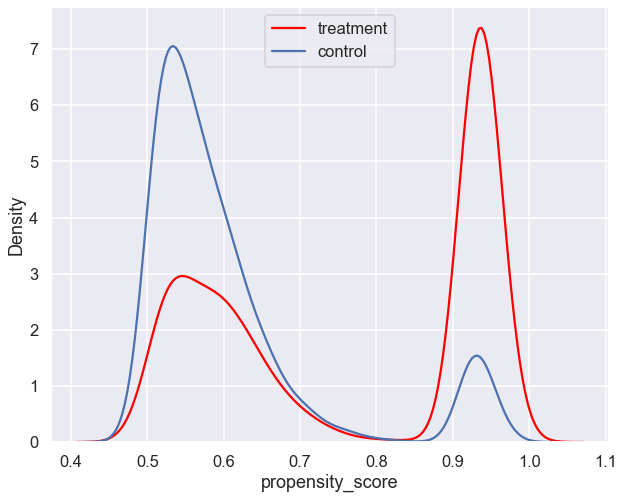

In [ ]:
# посмотрим различия в propensity score (вероятность совершить treatment) между treatment и control
sns.kdeplot(df_pred['propensity_score'][df_pred['treatment']], color = 'red', label = 'treatment')
sns.kdeplot(df_pred['propensity_score'][~df_pred['treatment']], label = 'control')
plt.legend()

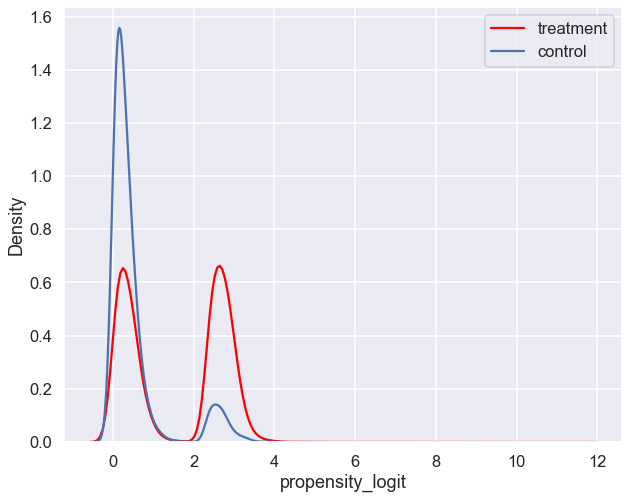

In [ ]:
# посмотрим различия в propensity logit между treatment и control
sns.kdeplot(df_pred['propensity_logit'][df_pred['treatment']], color = 'red', label = 'treatment')
sns.kdeplot(df_pred['propensity_logit'][~df_pred['treatment']], label = 'control')
plt.legend()

## 3. Проводим матчинг пар по PS logit

In [ ]:
%%time
psm.knn_matched(matcher='propensity_logit', replacement=True, caliper=None, drop_unmatched=True)

df_matched = psm.df_matched
df_matched = df_matched.merge(df_[cols_tc], on = ['id'])

df_matched

C:\Users\adilbek\Anaconda3\lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


Wall time: 36.4 s


,id,year_scaled,floor_scaled,rooms_scaled,price_scaled,square_scaled,is_it_capital_scaled,propensity_score,propensity_logit,treatment,matched_ID,year,floor,rooms,price,square,is_it_capital
0,0,0.80,0.07,-0.66,-0.06,-0.91,-0.91,0.55,0.19,0,17150.00,1975.00,5.00,1,8000,30.00,0
1,15,0.80,-1.04,-0.66,-0.04,-0.68,1.10,0.58,0.31,0,758.00,1981.00,0.00,1,10000,35.00,1
2,18,0.82,-0.60,-0.66,-0.01,-0.68,1.10,0.59,0.37,0,12241.00,1999.00,2.00,1,12000,35.00,1
3,23,0.81,-1.04,2.10,0.02,0.90,-0.91,0.57,0.29,0,17505.00,1990.00,0.00,3,15000,70.00,0
4,29,0.80,0.74,-0.66,-0.11,-0.32,-0.91,0.56,0.23,0,11300.00,1980.00,8.00,1,4000,43.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19404,11308,0.84,-0.38,0.72,0.02,2.03,-0.91,0.54,0.18,1,NaN,2017.00,3.00,2,15000,95.00,0
19405,6660,0.79,-0.82,0.72,-0.06,-0.01,-0.91,0.55,0.18,1,NaN,1970.00,1.00,2,8000,50.00,0
19406,6034,0.81,0.07,2.10,-0.04,0.45,-0.91,0.61,0.43,1,NaN,1988.00,5.00,3,10000,60.00,0
19407,14885,0.81,-0.82,-0.66,-0.04,-0.86,-0.91,0.52,0.07,1,NaN,1985.00,1.00,1,10000,31.00,0


Мы делаем matching 1:1 с помощью psm.knn_matched. Для каждого treatment = 0 (контрольная), находим похожее но с treatment = 1. Итоговый датафрейм это наблюдения с treatment = 0 & конкатинированные (добавленные значения по строкам) похожие наблюдения но с treatment = 1.

С помощью метода psm.knn_matched_12n можно делать matchin 1:N, где N это количество раз, когда мы делаем matching меньшего класса с большим классом.

Заметка: с помощью этих методов происходит matching меньшего класса treatment'a с большим классом, соотвественно, чтобы делать сопоставление для treatment = 1, важно чтобы в этой группе было меньше наблюдении чем в группе с treatment = 0.

In [ ]:
# подсчитаем кол-во наблюдений для матчинга
matched_ids = psm.matched_ids

to_match = df.query("id == @matched_ids.id.values.tolist()").treatment.value_counts()
matched = df.query("id == @matched_ids.matched_ID.values.tolist()").treatment.value_counts()

print('Для всех treatment = {0} значении:'.format(to_match.index[0]), to_match.values[0])
print('Есть matching для treatment = {0} значении:'.format(matched.index[0]), matched.values[0])

Для всех treatment = 0 значении: 9706
Есть matching для treatment = 1 значении: 5855


In [ ]:
# пример одного матча #13739
matched_ids[matched_ids['matched_ID'] == 13739]

,id,matched_ID
2655,6928,13739
8258,19591,13739
9704,35138,13739


In [ ]:
# пример одного матча  'matched_ID' == 17150  or #13739
df_matched[(df_matched['id'] == 6928) | (df_matched['id'] == 19591) | (df_matched['id'] == 35138)]

,id,year_scaled,floor_scaled,rooms_scaled,price_scaled,square_scaled,is_it_capital_scaled,propensity_score,propensity_logit,treatment,matched_ID,year,floor,rooms,price,square,is_it_capital
2655,6928,0.82,-0.82,0.72,-0.04,0.67,-0.91,0.54,0.15,0,13739.00,1995.00,1.00,2,10000,65.00,0
8258,19591,0.83,0.07,-0.66,-0.05,-0.46,-0.91,0.54,0.15,0,13739.00,2008.00,5.00,1,9000,40.00,0
9704,35138,0.81,-0.15,-0.66,-0.06,-0.86,-0.91,0.54,0.15,0,13739.00,1986.00,4.00,1,8000,31.00,0


In [ ]:
# делаем merge для матчинга наблюдений друг с другом
matching_for_class = to_match.index.values[0]

cols_1 = X.columns.tolist() + ['propensity_score']

matches = pd.merge(df_matched[df_matched[treatment]==matching_for_class].loc[:, cols_1 + ['matched_ID']],
                   df_pred.loc[:, cols_1], left_on='matched_ID',
                   right_index=True,
                   how='left', suffixes=('_c', '_t'))
# остается сматчиный датасет ставший теперь очень похож на control
matches

,year_c,floor_c,rooms_c,price_c,square_c,is_it_capital_c,propensity_score_c,matched_ID,year_t,floor_t,rooms_t,price_t,square_t,is_it_capital_t,propensity_score_t
0,1975.00,5.00,1,8000,30.00,0,0.55,17150.00,2017.00,6.00,1,14990,55.00,0,0.55
1,1981.00,0.00,1,10000,35.00,1,0.58,758.00,1985.00,4.00,2,16000,57.00,0,0.58
2,1999.00,2.00,1,12000,35.00,1,0.59,12241.00,1970.00,5.00,2,15000,46.00,0,0.59
3,1990.00,0.00,3,15000,70.00,0,0.57,17505.00,1990.00,0.00,3,15000,70.00,0,0.57
4,1980.00,8.00,1,4000,43.00,0,0.56,11300.00,1990.00,2.00,2,12000,45.00,0,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9701,1985.00,1.00,1,10000,31.00,0,0.52,14885.00,1985.00,1.00,1,10000,31.00,0,0.52
9702,2000.00,2.00,2,15000,55.00,0,0.56,5201.00,1979.00,2.00,2,10000,45.00,0,0.56
9703,1990.00,4.00,2,12000,52.00,0,0.57,6500.00,1970.00,3.00,2,13000,52.00,0,0.57
9704,1986.00,4.00,1,8000,31.00,0,0.54,13739.00,1978.00,4.00,1,7000,32.00,0,0.54


In [ ]:
# пример
matches[matches['matched_ID'] == 13739.00] #

,year_c,floor_c,rooms_c,price_c,square_c,is_it_capital_c,propensity_score_c,matched_ID,year_t,floor_t,rooms_t,price_t,square_t,is_it_capital_t,propensity_score_t
2655,1995.00,1.00,2,10000,65.00,0,0.54,13739.00,1978.00,4.00,1,7000,32.00,0,0.54
8258,2008.00,5.00,1,9000,40.00,0,0.54,13739.00,1978.00,4.00,1,7000,32.00,0,0.54
9704,1986.00,4.00,1,8000,31.00,0,0.54,13739.00,1978.00,4.00,1,7000,32.00,0,0.54


Для контрольной группы (где не было treatment'a) 9706 значении, мы сопоставили (matching) 5855 значении где был treatment.

Сверху можно видеть для наглядности датафрейм, как выглядят исходные данные с treatment = 0, то что значения слева с окончанием на _t. И справа их match с параметрами с окончанием на _с. Можно наблюдать что данные match'ей зачастую схожи по ковариатам с тем, чем делает сам matching.

## 4. Посмотрим как изменились распределения фичей. До и после матчинга

На графиках можем наблюдать как меняются распределения ковариат по treatment'у до и после матчинга. Можем видеть что все ковариаты стали очень похожими. Именно так и проверяется произошел ли "хороший" матчинг в PSM

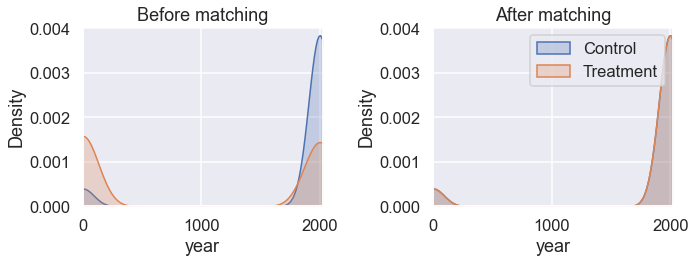

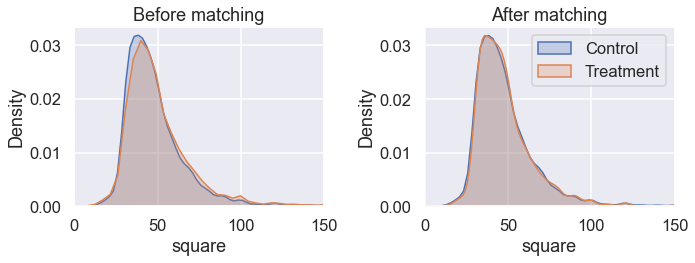

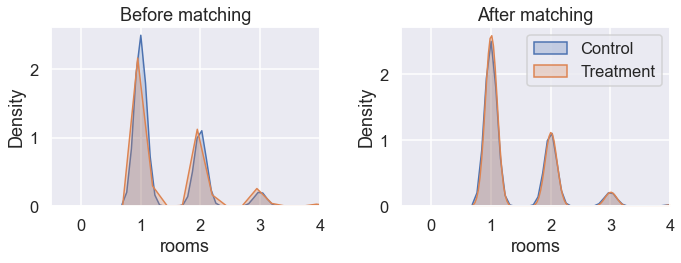

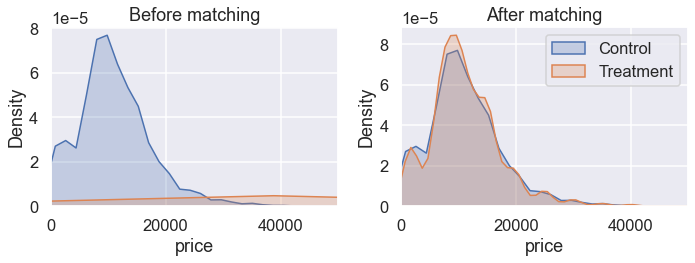

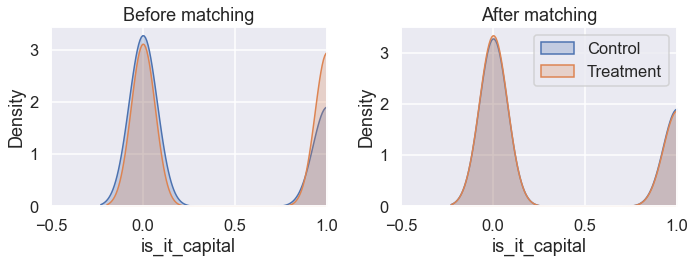

In [ ]:
cols_td = ['year', 'square', 'rooms', 'price', 'is_it_capital']
xlim = (df_pred[cols_td].quantile(0), df_pred[cols_td].quantile(0.99))

for x in cols_td:
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

    sns.kdeplot(data = df_pred[df_pred[treatment] == False], x = x, label = 'Control', fill=True, ax=ax[0])
    sns.kdeplot(data = df_pred[df_pred[treatment] == True], x = x, label = 'Treatment', fill=True, ax=ax[0])
    ax[0].set_title('Before matching')
    ax[0].set_xlim(xmin = -0.5, xmax = df_pred[x].quantile(0.995))

    sns.kdeplot(data = df_matched[df_matched[treatment] == False], x = x, label = 'Control', fill=True, ax=ax[1])
    sns.kdeplot(data = df_matched[df_matched[treatment] == True], x = x, label = 'Treatment', fill=True, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_xlim(xmin = -0.5, xmax = df_pred[x].quantile(0.995))

    plt.tight_layout()
    plt.legend()

Так же можно посмотреть на описательную статистику ковариат до и после matching'а и убедиться по цифрам что распределения стали очень похожими.

In [ ]:
# отрисуем разницу в средних между tretment и control до матчинга и после матчинга
cols_td = ['year', 'square', 'rooms', 'price', 'is_it_capital']

for i in cols_td:
    print(i)
    display(df_pred.groupby(treatment)[i].describe())
    display(df_matched.groupby(treatment)[i].describe())

year


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
False,9706.00,1812.45,579.00,0.00,1980.00,1991.00,2015.00,2022.00
True,25448.00,958.32,998.42,0.00,0.00,0.00,1998.00,2025.00


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,9706.00,1812.45,579.00,0.00,1980.00,1991.00,2015.00,2022.00
1,9703.00,1811.40,579.83,0.00,1980.00,1990.00,2014.00,2025.00


square


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
False,9706.00,48.43,19.29,0.00,36.00,45.00,55.00,480.00
True,25448.00,50.77,23.09,3.00,38.00,45.00,58.00,900.00


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,9706.00,48.43,19.29,0.00,36.00,45.00,55.00,480.00
1,9703.00,48.61,18.96,8.00,36.00,45.00,55.00,250.00


rooms


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
False,9706.00,1.42,0.65,1.00,1.00,1.00,2.00,16.00
True,25448.00,1.50,0.75,1.00,1.00,1.00,2.00,50.00


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,9706.00,1.42,0.65,1.00,1.00,1.00,2.00,16.00
1,9703.00,1.42,0.63,1.00,1.00,1.00,2.00,6.00


price


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
False,9706.00,11292.01,9730.16,18.00,7000.00,10000.00,15000.00,350000.00
True,25448.00,13623.90,94911.08,500.00,8000.00,12000.00,15000.00,15000000.00


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,9706.00,11292.01,9730.16,18.00,7000.00,10000.00,15000.00,350000.00
1,9703.00,11388.39,7845.82,500.00,7500.00,10000.00,15000.00,190000.00


is_it_capital


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
False,9706.00,0.37,0.48,0.00,0.00,0.00,1.00,1.00
True,25448.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,9706.00,0.37,0.48,0.00,0.00,0.00,1.00,1.00
1,9703.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00


Размер эффекта (разницы между ковариатами до и после) считается с помощью стандартизированной средняя разницы (Cohen's D) по ковариатам до и после matching'а.

Пороговые значения для разных размеров эффекта были показаны Cohen'ом (J. Cohen, “A Power Primer”, Quantitative Methods in Psychology, vol.111, no. 1, pp. 155–159, 1992).

Где размер эффекта классифицируется как:
* Маленький ≤ 0.2
* Средний ≤ 0.5
* Большой ≤ 0.8

В идеале после matching'а размеры эффекта, оказываемые переменнами, должны быть меньше.

Что и происходит на графике, размеры эффекта по всем ковариатам значительно уменьшаются после matching'a.

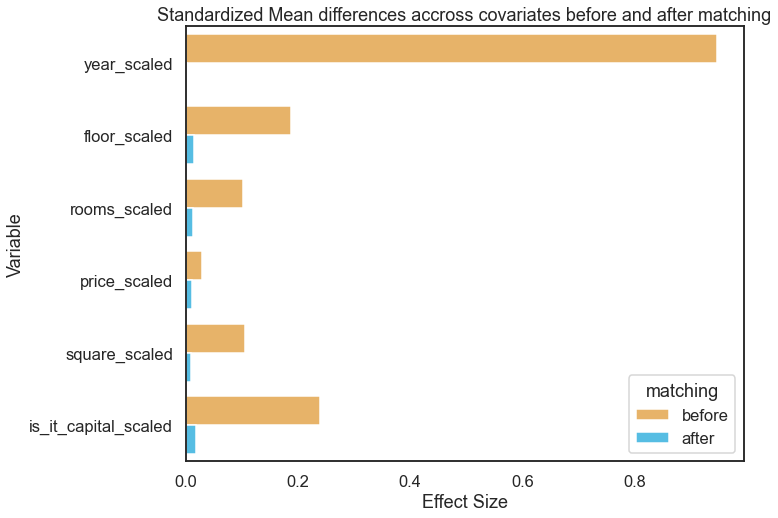

In [ ]:
# график показывающих различия между treatment и control для каждой фичи в datasete. Разницу показывают стандартизированную CohenВ
psm.effect_size_plot()

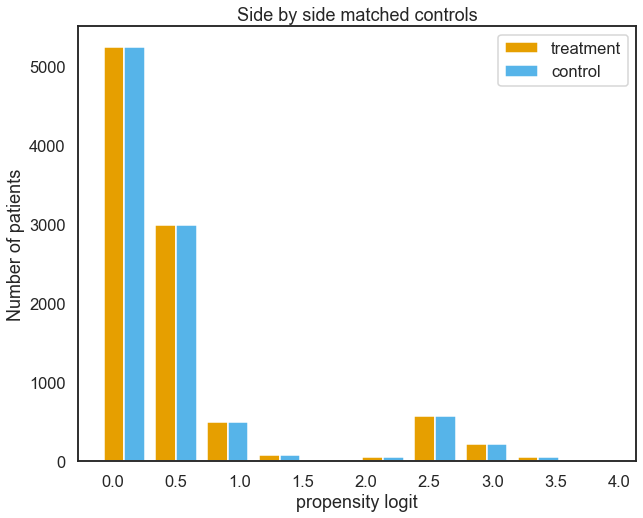

In [ ]:
# посмотрим как теперь распределены значения PS
psm.plot_match()

In [ ]:
sns.set(style='darkgrid', context='talk')

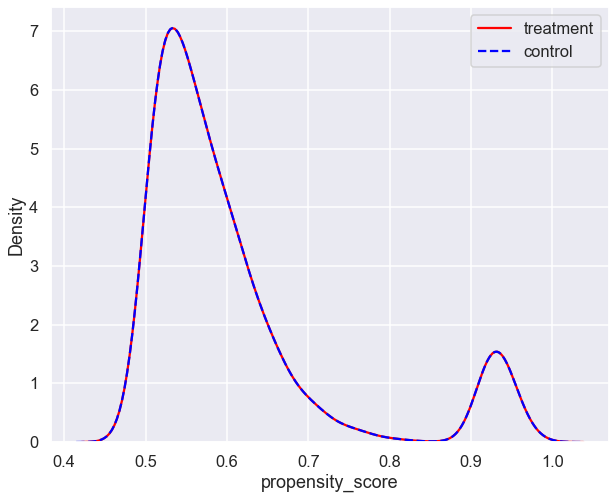

In [ ]:
# отрисуем значение PS после матчинга
sns.kdeplot(df_matched['propensity_score'][df_matched['treatment'] == 1], color = 'red', label = 'treatment')
sns.kdeplot(df_matched['propensity_score'][df_matched['treatment'] == 0], color = 'blue', ls = '--', label = 'control')
plt.legend()
# видим, что все поменялось и PS стал похож на контрольную группу

## 5. Нахождение эффекта
Для нахождения эффекта будем использовать новую библиотеку (causal inference). т.к. с ней удобнее и быстрее проводить PSM анализ

Когда мы убедились в хорошем matching'е, пришло время оценить сам эффект. Эффекты бывают разные

ATE - Average Treatment Effect (Средний эффект воздействия)

ATC - Average Treatment effect on the Control group (Средний эффект воздействия с контрольной группы)

ATT - Average Treatment effect on the Treatment group (Средний эффект воздействия с группы с воздействием)

Когда мы делаем Matching для одной стороны, как в нашем случае сделали Matching для группы где не было воздействия, то мы считаем ATC. При полном matching'е, можно считать ATE.

In [ ]:
# вспомним наши данные
df.head()

,year,floor,rooms,price,square,is_it_capital,treatment,cr,id
0,1975.00,5.00,1,8000,30.00,0,0,0.00,0
1,1970.00,2.00,1,8000,32.00,0,1,0.00,1
2,1980.00,1.00,1,7000,37.00,0,1,0.00,2
3,1975.00,3.00,1,5000,31.00,0,1,0.00,3
4,1985.00,8.00,1,10000,34.00,0,1,0.00,4


In [ ]:
%%time
# используем готовую библиотеку для рассчета PS и матчинга по этой метрике

y = df[outcome].values # обозначаем нашу целевую метрику
t = df[treatment].values # обозначим treatment
X_ = df[['year', 'floor', 'rooms', 'price', 'square', 'is_it_capital']]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_),
                 columns=X_.columns).values # создадим матрику фичей для получения PS

model = CausalModel(y, t, X_scaled) # инициируем модель причинной связи
print(model.summary_stats) # выведем summary по causal модели
model.est_propensity() # сделаем оценку propensity score с помощью логистической регресии
# результаты отработки модели
print(model.propensity)

propensity_score = model.raw_data['pscore'] # достаем рассчитанный propensity score

# сделаем logit преобразование из PS
propensity_score = np.where(propensity_score==1, 0.9999999999, propensity_score) # чтобы можно было делить на 0
a = propensity_score
b = 1 - propensity_score
c = a / b # (p|1-p) = шанс
propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values # преобразование в propensity_logit

model = CausalModel(y, t, propensity_logit) # инициируем модель причинной связи на уже по единственной метрике PS logit
model.est_via_matching() # производим матчинг

print(model.estimates) # выводим оценку эффекта


Summary Statistics

                      Controls (N_c=9706)       Treated (N_t=25448)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.006        0.051        0.006        0.063       -0.000

                      Controls (N_c=9706)       Treated (N_t=25448)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.631        0.591       -0.241        1.019       -1.047
             X1       -0.135        0.952        0.052        1.013        0.190
             X2       -0.074        0.892        0.028        1.037        0.105
             X3       -0.021        0.120        0.008        1.173        0.035
             X4       -0.077        0.872        0.029        1.043        0.110
      

In [ ]:
%%time
# а теперь проведем оценку через PSM но с дополнительным перебором ковариат с помощью функции est_propensity_s()
y = df[outcome].values
t = df[treatment].values
X_ = df[['year', 'floor', 'rooms', 'price', 'square', 'is_it_capital']]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_),
                 columns=X_.columns).values
model = CausalModel(y, t, X_scaled) # инициируем модель причинной связи
print(model.summary_stats) # выведем summary по causal модели
model.est_propensity_s() # метод автоматически перебирает фичи модели чтобы максимизировать правдоподобие модели
print(model.propensity) # результаты отработки модели

propensity_score = model.raw_data['pscore']
propensity_score = np.where(propensity_score==1, 0.9999999999, propensity_score)
a = propensity_score
b = 1 - propensity_score
c = a / b
propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values # преобразование в propensity_logit

model = CausalModel(y, t, propensity_logit) # инициируем модель причинной связи
model.est_via_matching()

# Оценка эффекта
print(model.estimates)


Summary Statistics

                      Controls (N_c=9706)       Treated (N_t=25448)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.006        0.051        0.006        0.063       -0.000

                      Controls (N_c=9706)       Treated (N_t=25448)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.631        0.591       -0.241        1.019       -1.047
             X1       -0.135        0.952        0.052        1.013        0.190
             X2       -0.074        0.892        0.028        1.037        0.105
             X3       -0.021        0.120        0.008        1.173        0.035
             X4       -0.077        0.872        0.029        1.043        0.110
      

Видим, что модель PSM также как и простой матчинг не нашли никакого эффекта

# Небольшой пример по ATC, ATT, ATE

In [ ]:
df = pd.DataFrame({
    'Имя': ['Рома', 'Вася', 'Саша', 'Маша'],
    'Treatment': [1, 0, 1, 0],
    'Итог, с treatment': [6, 6, 3, 3],
    'Итог, без treatment': [8, 8, 6, 6]
})

df

,Имя,Treatment,"Итог, с treatment","Итог, без treatment"
0,Рома,1,6,8
1,Вася,0,6,8
2,Саша,1,3,6
3,Маша,0,3,6


In [ ]:
df['TC'] = df.apply(lambda row: row['Итог, с treatment'] - row['Итог, без treatment'] \
                        if row['Treatment'] == 0 else None, axis=1)
df['TT'] = df.apply(lambda row: row['Итог, с treatment'] - row['Итог, без treatment'] \
                        if row['Treatment'] == 1 else None, axis=1)
df['TE'] = df.apply(lambda row: row['Итог, с treatment'] - row['Итог, без treatment'], axis=1)
df

,Имя,Treatment,"Итог, с treatment","Итог, без treatment",TC,TT,TE
0,Рома,1,6,8,NaN,-2.00,-2
1,Вася,0,6,8,-2.00,NaN,-2
2,Саша,1,3,6,NaN,-3.00,-3
3,Маша,0,3,6,-3.00,NaN,-3


In [ ]:
df.iloc[:, -3:].mean()

TC   -2.50
TT   -2.50
TE   -2.50
dtype: float64

Значения z и p-value можно вывести как табличку сверху, но нет самих значении в реализации этой библиотеки, поэтому можно посчитать руками.

С помощью пару математических трюков можем достать значения статистики z, а так же p-value имея этот z.

In [ ]:
# рассчитаем p-value вручную
metric = 'atc'
model_estimates = model.estimates.get('matching')
z = model_estimates.get(metric) / model_estimates.get(metric+'_se')
p_value_z = (1 - st.norm.cdf(abs(z))) * 2
print('z statistic =', z)
print('p-value =', p_value_z)

z statistic = 0.6564682660634575
p-value = 0.51152287928522


# 6. Сравнение с  АБ тестом. Кейс №2.
Далее поработаем с новыми данными. Хотим проанализировать датасет с объявлениями и выручкой, рандомно определяем контрольную и тестовую группу A и B. Данные синтетические. Т.е. тут нет никакого эффекта, мы будем его симулировать, чтобы можно было понять: работает ли PSM не хуже АБ-теста

In [ ]:
# получим датасет без эффекта
np.random.seed(16)

initial_data = pd.read_csv('dataset_for_psm_2.csv', index_col = 0) # возьмем

df_n = initial_data.sample(frac = 0.35) # извлечем выборку 35%

df_n.dropna(subset = ['price'], inplace = True)
df_n.fillna(0, inplace = True)

def assign_ab(df): # функция разбивающая на АБ
    df['group'] = np.random.randint(2, size=len(df))

assign_ab(df_n)

df_n.group.replace({0: 'A', 1: 'B'}, inplace = True) # переназовем для удобства в АБ-группы
df_n

,execution_date,advert_id,cat_id,price,year,floor,rooms,square,user_type,revenue,group
13932,2023-05-12,542324906.00,1,16700000.00,2022,9.00,1,37,2,0,A
24675,2023-05-12,546107529.00,1,17000000.00,1993,2.00,2,47,3,0,B
40891,2023-05-12,544566924.00,1,37500000.00,2004,1.00,3,76,1,0,A
43975,2023-05-12,545686811.00,1,45500000.00,2013,7.00,3,88,2,0,B
20962,2023-05-12,544362657.00,1,22000000.00,2014,4.00,1,42,1,0,A
...,...,...,...,...,...,...,...,...,...,...,...
44439,2023-05-12,540160939.00,1,45000000.00,2004,3.00,3,90,1,0,A
14821,2023-05-12,542003250.00,1,18000000.00,2021,5.00,1,38,1,0,A
32845,2023-05-12,545480976.00,1,35500000.00,2020,3.00,2,60,2,0,B
7547,2023-05-12,545713048.00,1,40500000.00,2016,7.00,3,99,1,0,A


In [ ]:
# проверим баланс разбиения
df_n.groupby(['group']).agg({'advert_id': 'count'}) / len(df_n)

,advert_id
group,
A,0.50
B,0.50


Имеем 50% - 50% для A - B групп

#### Добавим эффект от нововведения в treatment группу

In [ ]:
# добавляем использование treatment лишь некоторым в группе B. Так как и происходит в обычной жизни
df_n.loc[df_n['group'] == 'B', 'treatment'] = np.random.choice([0, 1],
                                                               size = len(df_n[df_n['group'] == 'B']),
                                                               p = [0.3, 0.7]) # 70% объявлений в группе Б воспользовались нововведением
df_n.treatment.fillna(0, inplace = True)
df_n

,execution_date,advert_id,cat_id,price,year,floor,rooms,square,user_type,revenue,group,treatment
13932,2023-05-12,542324906.00,1,16700000.00,2022,9.00,1,37,2,0,A,0.00
24675,2023-05-12,546107529.00,1,17000000.00,1993,2.00,2,47,3,0,B,1.00
40891,2023-05-12,544566924.00,1,37500000.00,2004,1.00,3,76,1,0,A,0.00
43975,2023-05-12,545686811.00,1,45500000.00,2013,7.00,3,88,2,0,B,1.00
20962,2023-05-12,544362657.00,1,22000000.00,2014,4.00,1,42,1,0,A,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
44439,2023-05-12,540160939.00,1,45000000.00,2004,3.00,3,90,1,0,A,0.00
14821,2023-05-12,542003250.00,1,18000000.00,2021,5.00,1,38,1,0,A,0.00
32845,2023-05-12,545480976.00,1,35500000.00,2020,3.00,2,60,2,0,B,1.00
7547,2023-05-12,545713048.00,1,40500000.00,2016,7.00,3,99,1,0,A,0.00


In [ ]:
# аггрегируем
ab_t = df_n.groupby(['group', 'treatment']).agg({'advert_id': 'count'})

b_p = (ab_t.values[2] / (ab_t.values[1] + ab_t.values[2]))[0]*100
a_p = (ab_t.values[1] / (ab_t.values[1] + ab_t.values[2]))[0]*100

print('Treatment 1 and 0 within B = {:.0f}% - {:.0f}%'.format(b_p, a_p))

ab_t

Treatment 1 and 0 within B = 71% - 29%


advert_id
group treatment           
A     0.00            7945
B     0.00            2322
      1.00            5577

Добавляем ещё больше treatment'a в зависимости от некоторых ковариат, в данном случае если год постройки и комнатности больше среднего то пусть будет treatment = 1.

In [ ]:
# добавляем доп treatment в зависимости от года постройки и комнатности. Чтобы появилось смещенная склонность к treatment
df_n.loc[(df_n['group'] == 'B') & (df_n['year'] >= int(df_n.year.quantile(0.8))) &\
          (df_n['rooms'] >= int(df_n.rooms.quantile(0.8))),
          'treatment'] = 1

In [ ]:
# посмотрим как изменилась ситуация
ab_t = df_n.groupby(['group', 'treatment']).agg({'advert_id': 'count'})

b_p = (ab_t.values[2] / (ab_t.values[1] + ab_t.values[2]))[0]*100
a_p = (ab_t.values[1] / (ab_t.values[1] + ab_t.values[2]))[0]*100

print('Treatment 1 and 0 within B = {:.0f}% - {:.0f}%'.format(b_p, a_p))

ab_t

Treatment 1 and 0 within B = 72% - 28%


advert_id
group treatment           
A     0.00            7945
B     0.00            2206
      1.00            5693

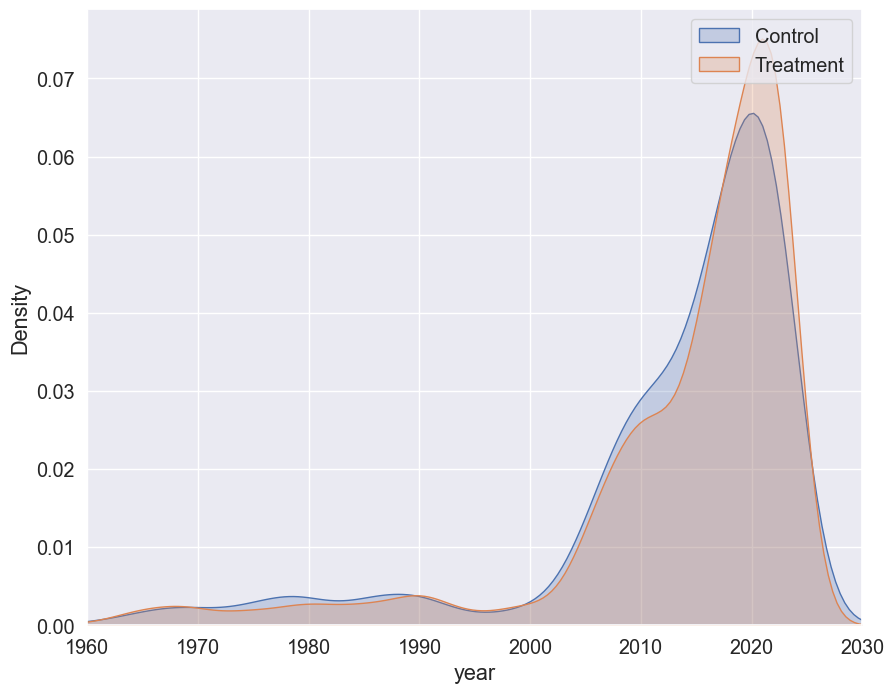

In [ ]:
# посмотрим как распределены фичи в зависимости от treatment
sns.kdeplot(data = df_n[(df_n['treatment']==0) & (df_n['group'] == 'B')], x = 'year', fill = True, label = 'Control')
sns.kdeplot(data = df_n[(df_n['treatment']==1) & (df_n['group'] == 'B')], x = 'year', fill = True, label = 'Treatment')
plt.xlim(1960, 2030)
plt.legend();

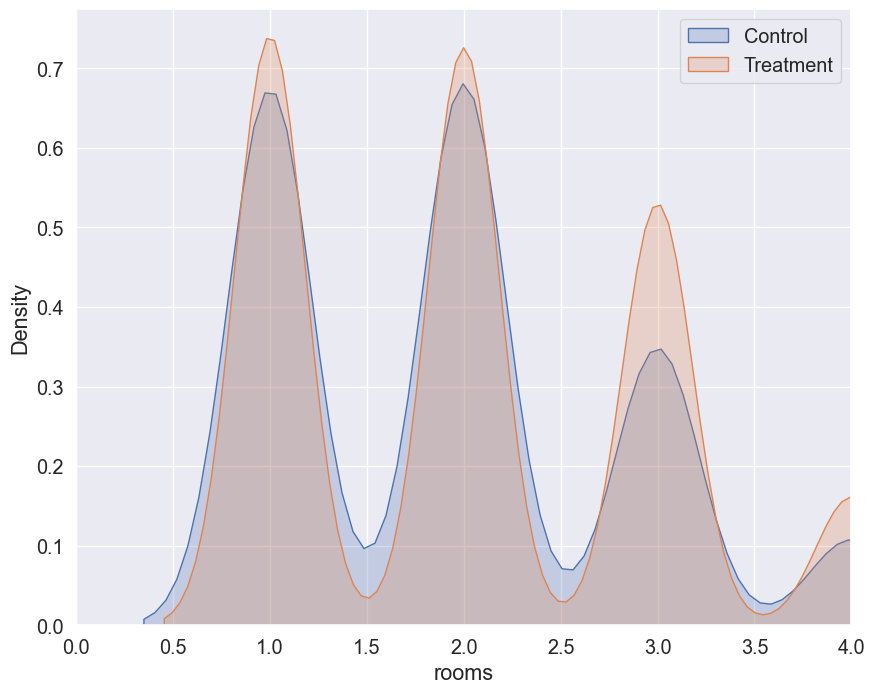

In [ ]:
# посмотрим как распределены фичи в зависимости от treatment
sns.kdeplot(data = df_n[(df_n['treatment']==0) & (df_n['group'] == 'B')], x = 'rooms', fill = True, label = 'Control')
sns.kdeplot(data = df_n[(df_n['treatment']==1) & (df_n['group'] == 'B')], x = 'rooms', fill = True, label = 'Treatment')
plt.xlim(0, 4)
plt.legend();

Так же можем наблюдать что мы добавили зависимость от этих двух ковариат, год постройки и комнатность, значения treatment'а для этих ковариат отличаются

In [ ]:
# пока эффекта не должно быть на revenue / проверим
df_n.groupby(['group']).agg({'revenue': 'mean'})

,revenue
group,
A,105.04
B,95.76


(0.0, 1000.0)

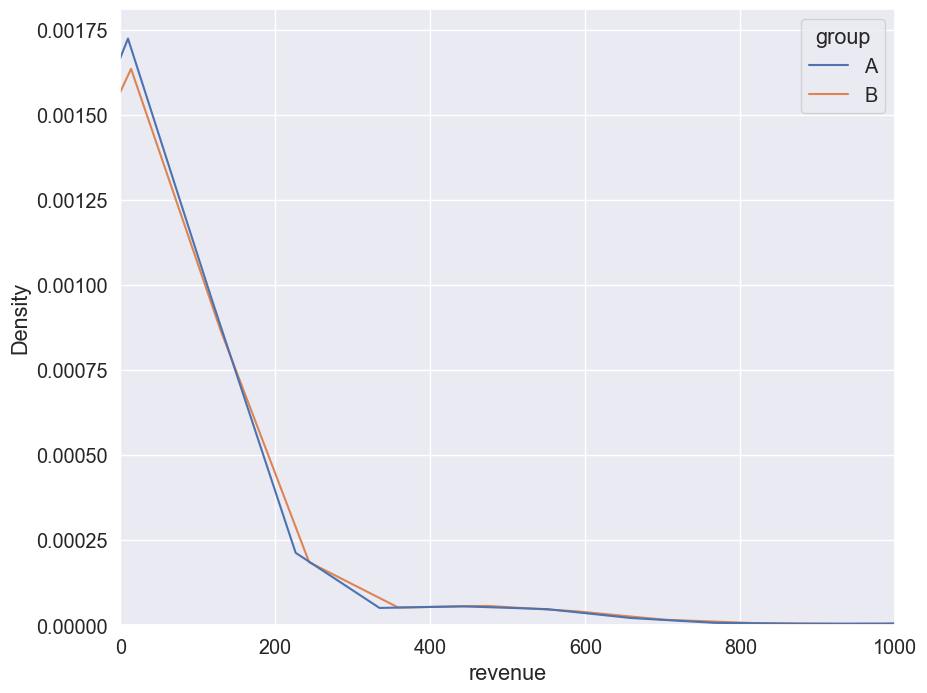

In [ ]:
sns.kdeplot(df_n, x= 'revenue', hue = 'group')
plt.xlim(0, 1000)

In [ ]:
# проверим разницу t-test на revenue (AA вариант)
values_A = df_n.query("group == 'A'").revenue
values_B = df_n.query("group == 'B'").revenue
print('Размер выборок A и B:', len(values_A), len(values_B))
print('Средняя в группе А', round(values_A.mean(), 2), 'Средняя в группе B', round(values_B.mean(), 2))
t_stat_ttest, p_value_ttest = ttest_ind(values_A, values_B)
print('T-test p-values =', p_value_ttest)

Размер выборок A и B: 7945 7899
Средняя в группе А 105.04 Средняя в группе B 95.76
T-test p-values = 0.3672144494627002


In [ ]:
%%time

y = df_n['revenue'].values
t = df_n['treatment'].values
X_ = df_n[['price', 'year', 'floor', 'rooms', 'square', 'user_type']]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_),
                 columns=X_.columns).values
model = CausalModel(y, t, X_scaled) # инициируем модель причинной связи
print(model.summary_stats)
model.est_propensity() # сделаем оценку propensity score с помощью логистической регресии

propensity_score = model.raw_data['pscore']
propensity_score = np.where(propensity_score==1, 0.9999999999, propensity_score)

a = propensity_score
b = 1 - propensity_score
c = a / b
propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values # преобразование в propensity_logit

model = CausalModel(y, t, propensity_logit) # инициируем модель причинной связи
model.est_via_matching()
print(model.estimates)


Summary Statistics

                     Controls (N_c=10151)        Treated (N_t=5693)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       97.665      582.983      105.313      750.333        7.647

                     Controls (N_c=10151)        Treated (N_t=5693)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.005        0.997        0.009        1.005        0.015
             X1       -0.007        1.002        0.012        0.997        0.019
             X2        0.005        0.994       -0.008        1.011       -0.013
             X3       -0.021        0.991        0.037        1.014        0.058
             X4       -0.012        1.007        0.021        0.986        0.034
      

## Добавим эффект

In [ ]:
# добвляем эффект для тех у ого был использованный treatment (+20%)
print('Среднее revenue до ', df_n['revenue'].mean())
df_n.loc[df_n['treatment'] == 1, 'revenue'] *= 1.2
print('Среднее revenue после добавления эффекта ', df_n['revenue'].mean())

Среднее revenue до  100.41327947488008
Среднее revenue после добавления эффекта  107.98139358747791


In [ ]:
rev_ab = df_n.groupby(['group']).agg({'revenue': 'mean'})
rev_tc = df_n.groupby(['treatment']).agg({'revenue': 'mean'})
print('Diff B VS A: =', round(rev_ab.values[1][0] - rev_ab.values[0][0], 2))
print('Diff T==1 VS T==0 =', round(rev_tc.values[1][0] - rev_tc.values[0][0], 2))
print(rev_ab)
print(rev_tc)

Diff B VS A: = 5.89
Diff T==1 VS T==0 = 28.71
       revenue
group         
A       105.04
B       110.94
           revenue
treatment         
0.00         97.67
1.00        126.38


(0.0, 1000.0)

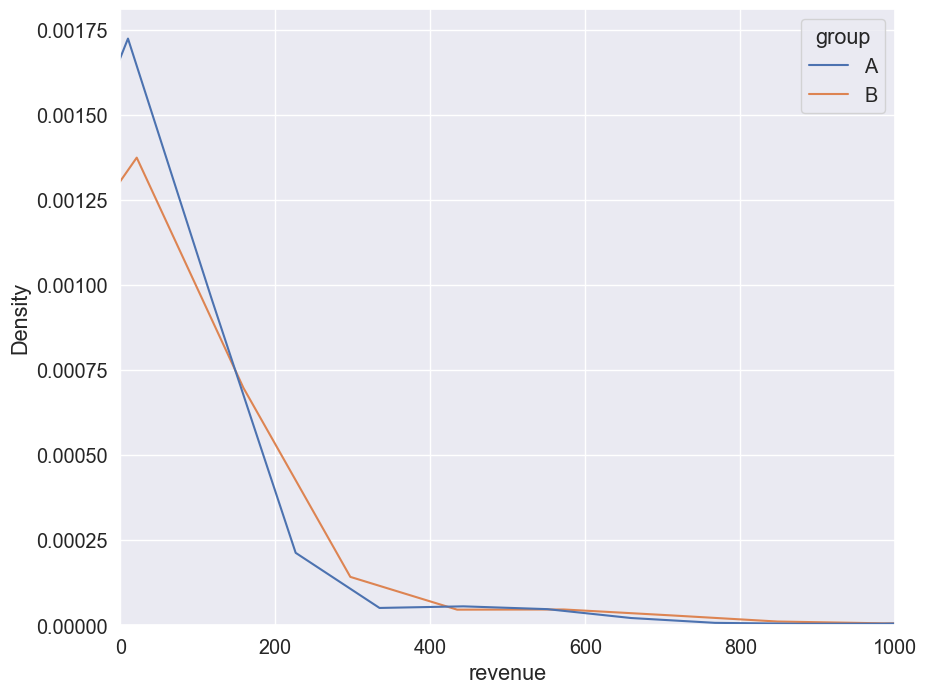

In [ ]:
sns.kdeplot(df_n, x= 'revenue', hue = 'group')
plt.xlim(0, 1000)

In [ ]:
# проверим эффект обычным t-test
values_A = df_n.query("group == 'A'").revenue
values_B = df_n.query("group == 'B'").revenue

print('Средняя в группе А', values_A.mean(), 'Средняя в группе B', values_B.mean())

t_stat_ttest, p_value_ttest = ttest_ind(values_A, values_B)
print('T-test p-values =', p_value_ttest)

Средняя в группе А 105.04266834487099 Средняя в группе B 110.93723256108368
T-test p-values = 0.6031595261774976


In [ ]:
%%time

y = df_n['revenue'].values
t = df_n['treatment'].values
X_ = df_n[['price', 'year', 'floor', 'rooms', 'square', 'user_type']]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_),
                 columns=X_.columns).values
model = CausalModel(y, t, X_scaled) # инициируем модель причинной связи
print(model.summary_stats)
model.est_propensity() # сделаем оценку propensity score с помощью логистической регресии
print(model.propensity) # результаты отработки модели

propensity_score = model.raw_data['pscore']
propensity_score = np.where(propensity_score==1, 0.9999999999, propensity_score)

a = propensity_score
b = 1 - propensity_score
c = a / b
propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values # преобразование в propensity_logit

model = CausalModel(y, t, propensity_logit) # инициируем модель причинной связи
model.est_via_matching()
print(model.estimates)


Summary Statistics

                     Controls (N_c=10151)        Treated (N_t=5693)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       97.665      582.983      126.375      900.400       28.710

                     Controls (N_c=10151)        Treated (N_t=5693)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.005        0.997        0.009        1.005        0.015
             X1       -0.007        1.002        0.012        0.997        0.019
             X2        0.005        0.994       -0.008        1.011       -0.013
             X3       -0.021        0.991        0.037        1.014        0.058
             X4       -0.012        1.007        0.021        0.986        0.034
      

**видим что PSM на тех же данных не стат значим. Реализовалась  ошибка FN/ Также как и в t-test**

Давайте попробуем прогнать симуляцию и оценить мощность PSM

In [ ]:
# напрямую из print(model.estimates) достать з-value не получится. рассчитаем его по доступным данным
metric = 'ate' # для сравнения с АБ. Будем оценивать p-value ATT эффекта
model_estimates = model.estimates.get('matching')
z = model_estimates.get(metric) / model_estimates.get(metric+'_se')
p_value_z = (1 - st.norm.cdf(abs(z))) * 2
print('z statistic =', z)
print('p-value =', p_value_z)

z statistic = 1.6362196712802242
p-value = 0.10179362088086163


## Анализ мощности PSM в сравнении с t-test

In [ ]:
# создадим функцию которая "заточена" под наши данные и многократно создает выборки
# проверяет мощность и статзначимость под конкретный эффект
# вариант для замера ATE эффекта в PSM
n_sim = 100
def process_iteration(effects):
    p_vals = []

    for effect in effects:
        df_n = initial_data.sample(frac=0.5) # достаем выборку
        df_n.dropna(subset=['price'], inplace=True)  # убираем и заменямем на 0 NA
        df_n.fillna(0, inplace=True)

        assign_ab(df_n)
        df_n.group.replace({0: 'A', 1: 'B'}, inplace=True) # раздаем группы

        df_n.loc[df_n['group'] == 'B', 'treatment'] = np.random.choice([0, 1],
                                                                       size=len(df_n[df_n['group'] == 'B']),
                                                                       p=[0.3, 0.7]) # treatment используют только 0,6

        df_n.loc[(df_n['group'] == 'B') & (df_n['year'] >= int(df_n.year.quantile(0.8))) &\
                 (df_n['rooms'] >= int(df_n.rooms.quantile(0.8))), # досыпаем treatment в зависимости от имеющихся данных
                 'treatment'] = 1
        df_n.treatment.fillna(0, inplace=True)

        df_n.loc[df_n['treatment'] == 1, 'revenue'] *= (1 + effect) # добавляем эффект

        rev_ab = df_n.groupby(['group']).agg({'revenue': 'mean'})
        b_minus_a = rev_ab.values[1][0] - rev_ab.values[0][0]

        # t-test
        values_A = df_n.query("group == 'A'").revenue
        values_B = df_n.query("group == 'B'").revenue

        t_stat_ttest, p_value_ttest = ttest_ind(values_A, values_B)

        # PSM
        y = df_n['revenue'].values
        t = df_n['treatment'].values
        X_ = df_n[['price', 'year', 'floor', 'rooms', 'square', 'user_type']]
        X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_),
                         columns=X_.columns).values
        model = CausalModel(y, t, X_scaled) # инициируем модель причинной связи
        model.est_propensity() # сделаем оценку propensity score с помощью логистической регресии

        propensity_score = model.raw_data['pscore']
        propensity_score = np.where(propensity_score==1, 0.9999999999, propensity_score)

        a = propensity_score
        b = 1 - propensity_score
        c = a / b
        propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values # преобразование в propensity_logit

        model = CausalModel(y, t, propensity_logit) # инициируем модель причинной связи
        model.est_via_matching()

        metric = 'ate'
        model_estimates = model.estimates.get('matching')
        z = model_estimates.get(metric) / model_estimates.get(metric+'_se')
        p_value_z = (1 - st.norm.cdf(abs(z))) * 2
        p_vals.append(p_value_ttest)
        p_vals.append(p_value_z)

    return p_vals

effects = [0, 0.01, 0.05, 0.1, 0.2, 0.5]
results = Parallel(n_jobs=-1)( #распараллелим вычисления
    delayed(process_iteration)(effects) for _ in tqdm(range(n_sim))
)

a_ate = pd.DataFrame(results, columns = ['p_value_1_0_t', 'p_value_1_0_p', # значение p-value для эффекта 1-0 для t и для PSM (p)
                                     'p_value_1_01_t', 'p_value_1_01_p',
                                     'p_value_1_05_t', 'p_value_1_05_p',
                                     'p_value_1_1_t', 'p_value_1_1_p',
                                     'p_value_1_2_t', 'p_value_1_2_p',
                                     'p_value_1_5_t', 'p_value_1_5_p'])



  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:03, 25.58it/s]

  8%|▊         | 8/100 [00:17<00:03, 25.58it/s]

 16%|█▌        | 16/100 [02:40<16:32, 11.82s/it]

 24%|██▍       | 24/100 [05:55<22:13, 17.55s/it]

 32%|███▏      | 32/100 [09:12<23:02, 20.33s/it]

 40%|████      | 40/100 [11:32<19:17, 19.29s/it]

 48%|████▊     | 48/100 [13:59<16:26, 18.98s/it]

 56%|█████▌    | 56/100 [16:01<13:01, 17.77s/it]

 64%|██████▍   | 64/100 [18:10<10:21, 17.27s/it]

 72%|███████▏  | 72/100 [20:32<08:07, 17.41s/it]

 80%|████████  | 80/100 [23:05<05:58, 17.94s/it]

 88%|████████▊ | 88/100 [25:17<03:29, 17.49s/it]

100%|██████████| 100/100 [27:13<00:00, 16.33s/it][A


In [ ]:
# создадим функцию которая "заточена" под наши данные и многократно создает выборки
# проверяет мощность и статзначимость под конкретный эффект
# вариант для замера ATT эффекта в PSM
n_sim = 100
def process_iteration(effects):
    p_vals = []

    for effect in effects:
        df_n = initial_data.sample(frac=0.5) # достаем выборку
        df_n.dropna(subset=['price'], inplace=True)  # убираем и заменямем на 0 NA
        df_n.fillna(0, inplace=True)

        assign_ab(df_n)
        df_n.group.replace({0: 'A', 1: 'B'}, inplace=True) # раздаем группы

        df_n.loc[df_n['group'] == 'B', 'treatment'] = np.random.choice([0, 1],
                                                                       size=len(df_n[df_n['group'] == 'B']),
                                                                       p=[0.3, 0.7]) # treatment используют только 0,6

        df_n.loc[(df_n['group'] == 'B') & (df_n['year'] >= int(df_n.year.quantile(0.8))) &\
                 (df_n['rooms'] >= int(df_n.rooms.quantile(0.8))), # досыпаем treatment в зависимости от имеющихся данных
                 'treatment'] = 1
        df_n.treatment.fillna(0, inplace=True)

        df_n.loc[df_n['treatment'] == 1, 'revenue'] *= (1 + effect) # добавляем эффект

        rev_ab = df_n.groupby(['group']).agg({'revenue': 'mean'})
        b_minus_a = rev_ab.values[1][0] - rev_ab.values[0][0]

        # t-test
        values_A = df_n.query("group == 'A'").revenue
        values_B = df_n.query("group == 'B'").revenue

        t_stat_ttest, p_value_ttest = ttest_ind(values_A, values_B)

        # PSM
        y = df_n['revenue'].values
        t = df_n['treatment'].values
        X_ = df_n[['price', 'year', 'floor', 'rooms', 'square', 'user_type']]
        X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_),
                         columns=X_.columns).values
        model = CausalModel(y, t, X_scaled) # инициируем модель причинной связи
        model.est_propensity() # сделаем оценку propensity score с помощью логистической регресии

        propensity_score = model.raw_data['pscore']
        propensity_score = np.where(propensity_score==1, 0.9999999999, propensity_score)

        a = propensity_score
        b = 1 - propensity_score
        c = a / b
        propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values # преобразование в propensity_logit

        model = CausalModel(y, t, propensity_logit) # инициируем модель причинной связи
        model.est_via_matching()

        metric = 'att'
        model_estimates = model.estimates.get('matching')
        z = model_estimates.get(metric) / model_estimates.get(metric+'_se')
        p_value_z = (1 - st.norm.cdf(abs(z))) * 2
        p_vals.append(p_value_ttest)
        p_vals.append(p_value_z)

    return p_vals

effects = [0, 0.01, 0.05, 0.1, 0.2, 0.5]
results = Parallel(n_jobs=-1)( #распараллелим вычисления
    delayed(process_iteration)(effects) for _ in tqdm(range(n_sim))
)

a_att = pd.DataFrame(results, columns = ['p_value_1_0_t', 'p_value_1_0_p', # значение p-value для эффекта 1-0 для t и для PSM (p)
                                     'p_value_1_01_t', 'p_value_1_01_p',
                                     'p_value_1_05_t', 'p_value_1_05_p',
                                     'p_value_1_1_t', 'p_value_1_1_p',
                                     'p_value_1_2_t', 'p_value_1_2_p',
                                     'p_value_1_5_t', 'p_value_1_5_p'])



  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [01:34<08:17,  5.92s/it]

 24%|██▍       | 24/100 [03:49<13:16, 10.49s/it]

 32%|███▏      | 32/100 [05:33<12:55, 11.40s/it]

 40%|████      | 40/100 [07:23<12:13, 12.23s/it]

 48%|████▊     | 48/100 [09:44<12:09, 14.02s/it]

 56%|█████▌    | 56/100 [11:50<10:41, 14.59s/it]

 64%|██████▍   | 64/100 [13:47<08:45, 14.59s/it]

 72%|███████▏  | 72/100 [15:56<07:01, 15.06s/it]

 80%|████████  | 80/100 [17:58<05:02, 15.14s/it]

 88%|████████▊ | 88/100 [20:29<03:15, 16.26s/it]

100%|██████████| 100/100 [22:52<00:00, 13.73s/it][A


In [ ]:
a_ate

,p_value_1_0_t,p_value_1_0_p,p_value_1_01_t,p_value_1_01_p,p_value_1_05_t,p_value_1_05_p,p_value_1_1_t,p_value_1_1_p,p_value_1_2_t,p_value_1_2_p,p_value_1_5_t,p_value_1_5_p
0,0.91,0.79,0.15,0.38,0.36,0.66,0.87,0.51,0.20,0.43,0.00,0.00
1,0.88,0.96,0.60,0.72,0.59,0.75,0.60,0.55,0.01,0.15,0.00,0.05
2,0.42,0.96,0.82,0.88,0.48,0.97,0.37,0.74,0.00,0.01,0.00,0.00
3,0.38,0.70,0.22,0.44,0.98,0.46,0.37,0.18,0.17,0.12,0.00,0.03
4,0.50,0.78,0.55,0.26,0.13,0.68,1.00,0.56,0.04,0.12,0.09,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.72,0.78,0.18,0.52,0.42,0.84,0.81,0.58,0.72,0.86,0.15,0.06
96,0.89,0.22,0.65,0.76,0.45,0.93,0.59,0.19,0.02,0.13,0.04,0.02
97,0.16,0.72,0.93,0.51,0.60,0.51,0.89,0.74,0.01,0.08,0.00,0.00
98,0.76,0.26,0.76,0.53,0.14,0.06,0.07,0.17,0.73,0.70,0.02,0.08


In [ ]:
res_ate = pd.DataFrame()
res_ate = pd.DataFrame(pd.concat([a_ate.iloc[:, :2].lt(0.05).sum(),
                        a_ate.iloc[:, 2:].ge(0.05).sum()])).T
res_ate /= n_sim
res_ate

,p_value_1_0_t,p_value_1_0_p,p_value_1_01_t,p_value_1_01_p,p_value_1_05_t,p_value_1_05_p,p_value_1_1_t,p_value_1_1_p,p_value_1_2_t,p_value_1_2_p,p_value_1_5_t,p_value_1_5_p
0,0.05,0.00,0.97,1.00,0.95,0.99,0.94,0.98,0.69,0.86,0.11,0.19


In [ ]:
a_att

,p_value_1_0_t,p_value_1_0_p,p_value_1_01_t,p_value_1_01_p,p_value_1_05_t,p_value_1_05_p,p_value_1_1_t,p_value_1_1_p,p_value_1_2_t,p_value_1_2_p,p_value_1_5_t,p_value_1_5_p
0,0.03,0.86,0.84,0.85,0.46,0.68,0.63,0.91,0.28,0.15,0.00,0.05
1,0.10,0.19,0.84,0.99,0.88,0.63,0.51,0.44,0.01,0.03,0.01,0.02
2,0.51,0.23,0.22,0.61,0.41,0.77,0.53,0.98,0.63,0.62,0.00,0.02
3,0.56,0.79,0.56,0.31,0.18,0.09,0.84,0.37,0.10,0.03,0.00,0.00
4,0.60,0.50,0.27,0.30,0.51,0.96,0.83,0.24,0.62,0.62,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.54,0.25,0.83,1.00,0.80,0.58,0.62,0.30,0.57,0.54,0.00,0.04
96,0.75,0.44,0.11,0.63,0.96,0.59,0.79,0.82,0.03,0.11,0.02,0.02
97,0.57,0.86,0.78,0.78,0.51,0.95,0.92,0.78,0.32,0.85,0.02,0.02
98,0.04,0.25,0.93,0.39,0.81,0.80,0.60,0.65,0.02,0.05,0.00,0.00


In [ ]:
res_att = pd.DataFrame()
res_att = pd.DataFrame(pd.concat([a_att.iloc[:, :2].lt(0.05).sum(),
                        a_att.iloc[:, 2:].ge(0.05).sum()])).T
res_att /= n_sim
res_att

,p_value_1_0_t,p_value_1_0_p,p_value_1_01_t,p_value_1_01_p,p_value_1_05_t,p_value_1_05_p,p_value_1_1_t,p_value_1_1_p,p_value_1_2_t,p_value_1_2_p,p_value_1_5_t,p_value_1_5_p
0,0.09,0.01,0.98,0.98,0.94,0.97,0.96,0.98,0.62,0.84,0.06,0.28


In [ ]:
pd.concat([res_ate, res_att], keys = ['ATE', 'ATT'])

,,p_value_1_0_t,p_value_1_0_p,p_value_1_01_t,p_value_1_01_p,p_value_1_05_t,p_value_1_05_p,p_value_1_1_t,p_value_1_1_p,p_value_1_2_t,p_value_1_2_p,p_value_1_5_t,p_value_1_5_p
ATE,0,0.05,0.00,0.97,1.00,0.95,0.99,0.94,0.98,0.69,0.86,0.11,0.19
ATT,0,0.09,0.01,0.98,0.98,0.94,0.97,0.96,0.98,0.62,0.84,0.06,0.28


Citations:
* https://builtin.com/data-science/propensity-score-matching
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/pdf/nihms200640.pdf (Matching methods for causal inference: A review and a look forward)